## Problem Statement
New York city is one of such advanced city with extensive use of transportation via subways, buses and taxi services. New York has more then 10,000 plus taxi and nearly 50% of population doesn’t have a personal vehicle. Due to this facts most people used taxi has a there primary mode of transport and it accounts for more than 100 millions taxi trips per year.

<img src="Newyorkcity_taxi_motion_banner.jpg">

Ride hailing services are services that use online-enabled platforms to connect between passengers and local drivers using their personal vehicles. In most cases they are a comfortable method for door-to-door transport. Usually they are cheaper than using licensed taxicabs. Examples of ride hailing services include Uber and Lyft.

To improve the efficiency of taxi dispatching systems for such services, it is important to be able to predict how long a driver will have his taxi occupied. If a dispatcher knew approximately when a taxi driver would be ending their current ride, they would be better able to identify which driver to assign to each pickup request.



## 1. Exploratory Data Analysis
Let's check the data files! According to the data description we should find the following columns:

 - **id** - a unique identifier for each trip
 - **vendor_id** - a code indicating the provider associated with the trip record
 - **pickup_datetime** - date and time when the meter was engaged
 - **dropoff_datetime** - date and time when the meter was disengaged
 - **passenger_count** - the number of passengers in the vehicle (driver entered value)
 - **pickup_longitude** - the longitude where the meter was engaged
 - **pickup_latitude** - the latitude where the meter was engaged
 - **dropoff_longitude** - the longitude where the meter was disengaged
 - **dropoff_latitude** - the latitude where the meter was disengaged
 - **store_and_fwd_flag** - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server (Y=store and forward; N=not a store and forward trip)
 - **trip_duration** - (target) duration of the trip in seconds

Here, we have 2 variables dropoff_datetime and store_and_fwd_flag which are not available before the trip starts and hence will not be used as features to the model.

### Load Libraries
We will load libraries required to build models and validation sets

In [13]:
%matplotlib inline
import numpy as np 
import pandas as pd
import datetime as dt
from datetime import timedelta 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression 
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import KFold
###from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor


### Load Data

In [4]:
df = pd.read_csv('nyc_taxi_final.zip')

### Missing Values

Check for the missing values in the data set.

In [3]:
np.sum(pd.isnull(df))

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

No missing values can be found in this data set

### Reformatting features & Checking consistency

Data conversion into the correct format Eg: String to Date/Time format

In [6]:
# converting strings to datetime features
df['pickup_datetime'] = pd.to_datetime(df.pickup_datetime)
df['dropoff_datetime'] = pd.to_datetime(df.dropoff_datetime)

# Converting yes/no flag to 1 and 0
df['store_and_fwd_flag'] = 1 * (df.store_and_fwd_flag.values == 'Y')

df['check_trip_duration'] = (df['dropoff_datetime'] - df['pickup_datetime']).map(lambda x: x.total_seconds())

duration_difference = df[np.abs(df['check_trip_duration'].values  - df['trip_duration'].values) > 1]
duration_difference.shape

(0, 12)

### Target Variable( "Trip Duration") Exploration


In [5]:
df['trip_duration'].describe()/3600 # Trip duration in hours

count    202.589444
mean       0.264508
std        1.073507
min        0.000278
25%        0.110278
50%        0.184167
75%        0.298611
max      538.815556
Name: trip_duration, dtype: float64

There is a trip with duration of ~539 hours. This is a huge outlier and might create problems at the prediction stage. One idea is to log transform the trip duration before prediction to visualise it better.

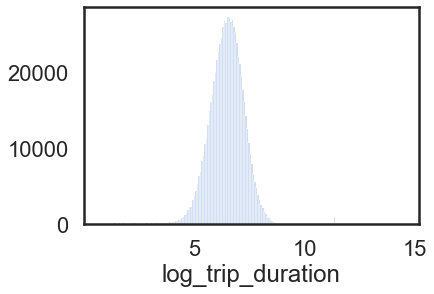

In [38]:
df['log_trip_duration'] = np.log(df['trip_duration'].values + 1)
sns.distplot(df['log_trip_duration'], kde = False, bins = 200)
plt.show()

01. The curve peak is nearly at exp(6.5) = 17mins
02. There is a outlier near exp(12)
03. There are some short time trips <(exp(2))

### Univariate Visualization

Text(0, 0.5, 'Total number of pickups')

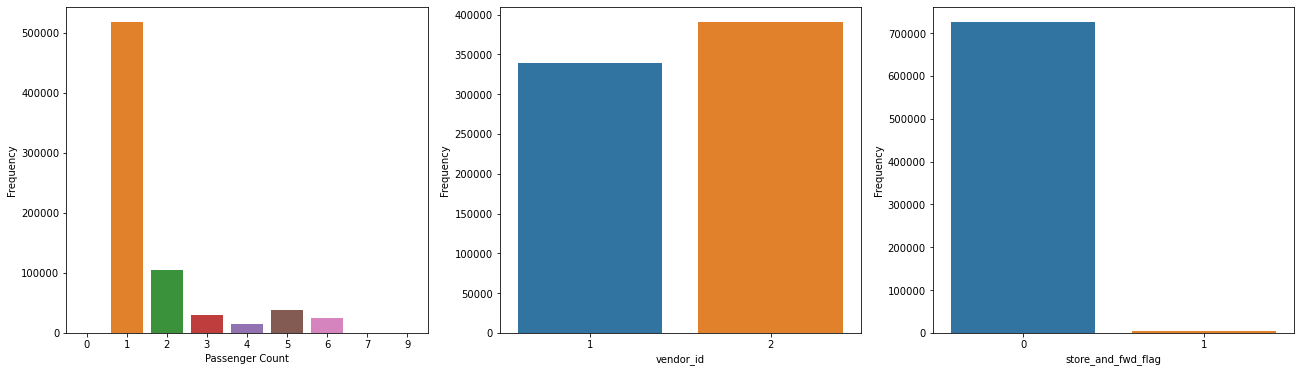

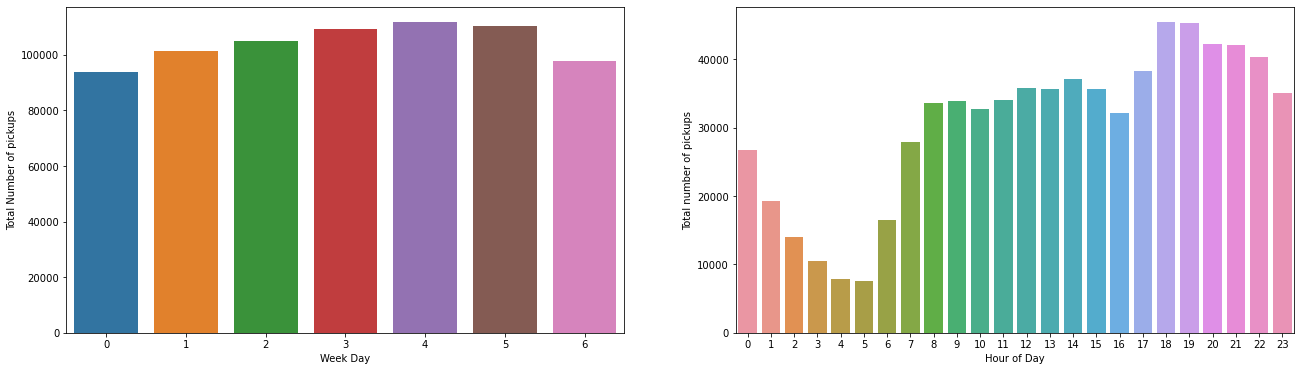

In [7]:
# Binary Features
plt.figure(figsize=(22, 6))
#fig, axs = plt.subplot(ncols=2)

# Passenger Count
plt.subplot(131)
sns.countplot(df['passenger_count'])
plt.xlabel('Passenger Count')
plt.ylabel('Frequency')


# vendor_id
plt.subplot(132)
sns.countplot(df['vendor_id'])
plt.xlabel('vendor_id')
plt.ylabel('Frequency')

# store_and_fwd_flag
plt.subplot(133)
sns.countplot(df['store_and_fwd_flag'])
plt.xlabel('store_and_fwd_flag')
plt.ylabel('Frequency')


df['day_of_week'] = df['pickup_datetime'].dt.weekday
df['hour_of_day'] = df['pickup_datetime'].dt.hour


# Datetime features
plt.figure(figsize=(22, 6))

# Passenger Count
plt.subplot(121)
sns.countplot(df['day_of_week'])
plt.xlabel('Week Day')
plt.ylabel('Total Number of pickups')

# vendor_id
plt.subplot(122)
sns.countplot(df['hour_of_day'])
plt.xlabel('Hour of Day')
plt.ylabel('Total number of pickups')


### Bivariate Relations with Target(trip duration)

01. Trip Duration vs Weekday
02. vendor_id vs Trip Duration
03. Trip Duration vs Passenger Count
04. Mean Trip Duration Vendor Wise
05. Median Trip Duration Vendor Wise

### 01.Trip Duration vs Weekday


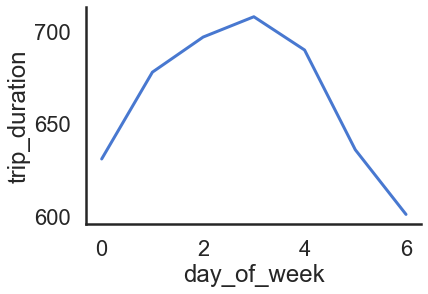

In [22]:
summary_wdays_avg_duration = pd.DataFrame(df.groupby(['day_of_week'])['trip_duration'].median())
summary_wdays_avg_duration.reset_index(inplace = True)
summary_wdays_avg_duration['unit']=1

sns.set(style="white", palette="muted", color_codes=True)
sns.set_context("poster")
g= sns.lineplot(data=summary_wdays_avg_duration, x="day_of_week", units = "unit", y="trip_duration",estimator=None)

g.set_xlabel('day_of_week')
g.set_ylabel('trip_duration')
sns.despine(bottom = False)

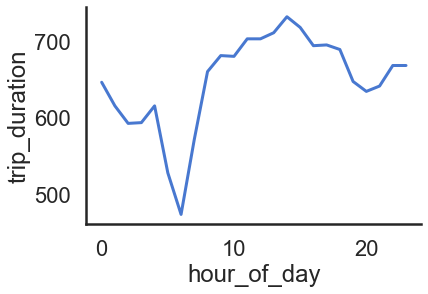

In [23]:
summary_wdays_avg_duration = pd.DataFrame(df.groupby(['hour_of_day'])['trip_duration'].median())
summary_wdays_avg_duration.reset_index(inplace = True)
summary_wdays_avg_duration['unit']=1

sns.set(style="white", palette="muted", color_codes=True)
sns.set_context("poster")
g= sns.lineplot(data=summary_wdays_avg_duration, x="hour_of_day", units = "unit", y="trip_duration",estimator=None)

g.set_xlabel('hour_of_day')
g.set_ylabel('trip_duration')
sns.despine(bottom = False)

### 02.vendor_id vs Trip Duration

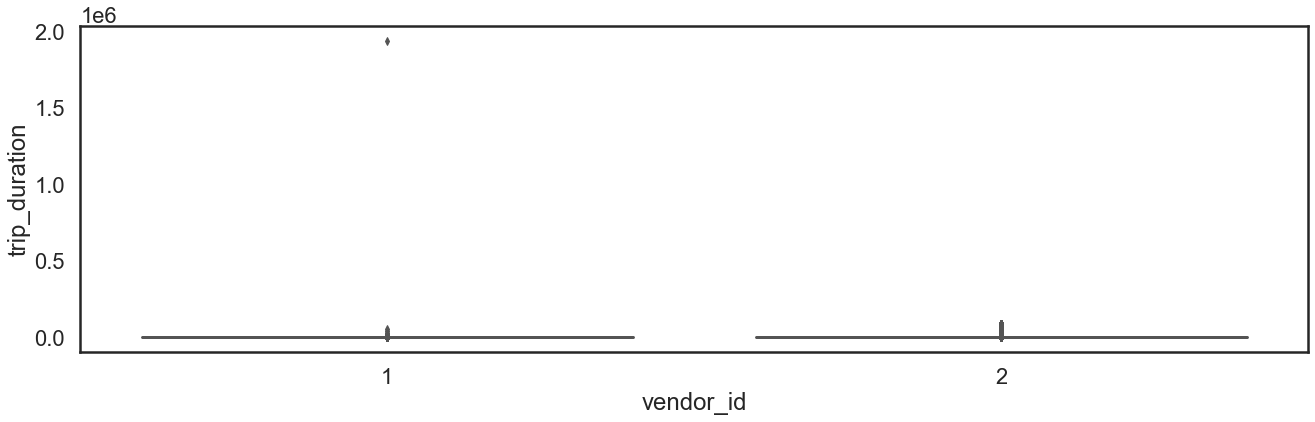

In [24]:
plt.figure(figsize=(22, 6))
sns.boxplot(x="vendor_id", y="trip_duration", data=df)
plt.show()

There are some outliers in the data set. So we have to ;
1. Remove the huge outliers and plot again 
2. Look at median trip duration for both vendors on hourly basis

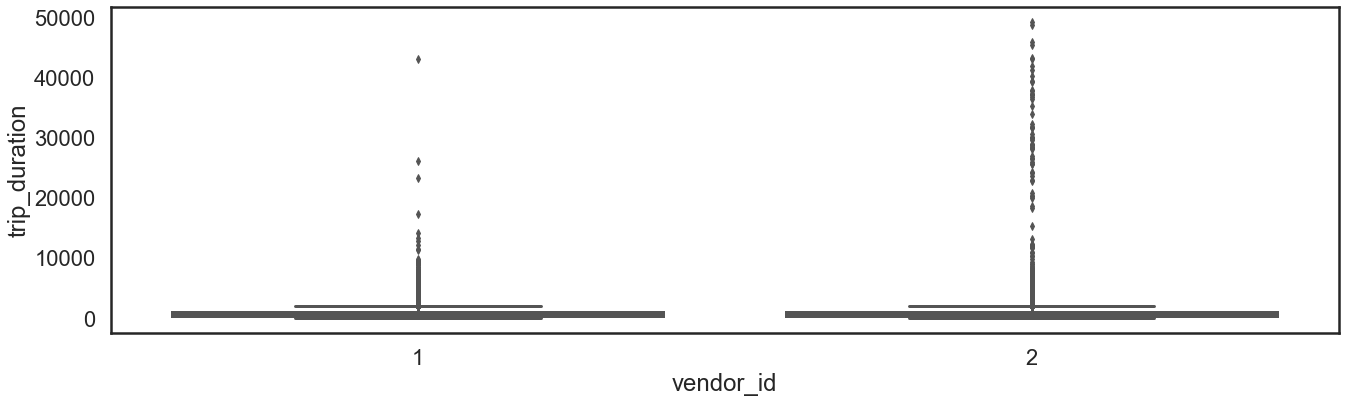

In [25]:
plt.figure(figsize=(22, 6))
df_sub = df[df['trip_duration'] < 50000]
sns.boxplot(x="vendor_id", y="trip_duration", data=df_sub)
plt.show()

### 03.Trip Duration vs Passenger Count

we have taken a cutoff of 10000 seconds and used a boxplot.

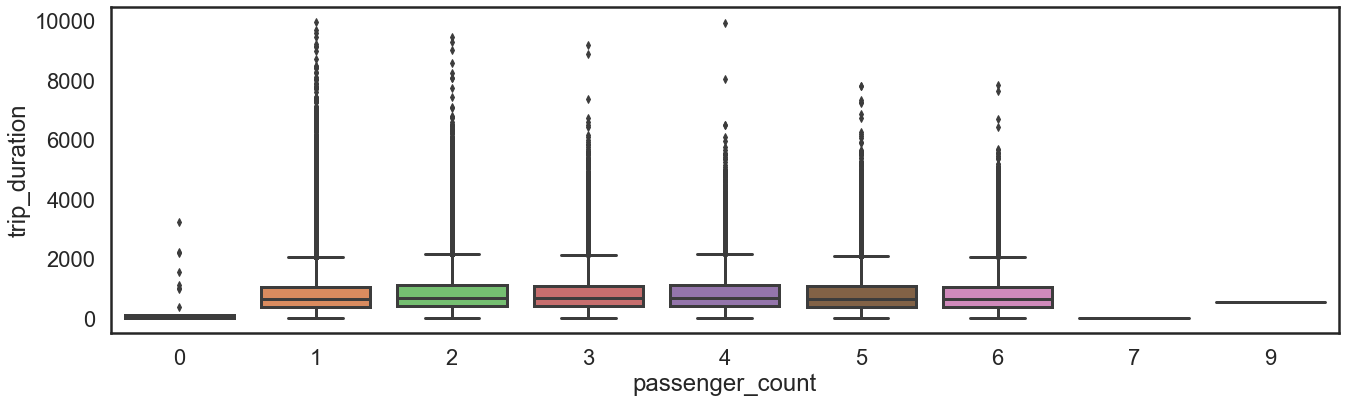

In [26]:
df.passenger_count.value_counts()
plt.figure(figsize=(22, 6))
df_sub = df[df['trip_duration'] < 10000]
sns.boxplot(x="passenger_count", y="trip_duration", data=df_sub)
plt.show()


### 04.Mean Trip Duration Vendor Wise

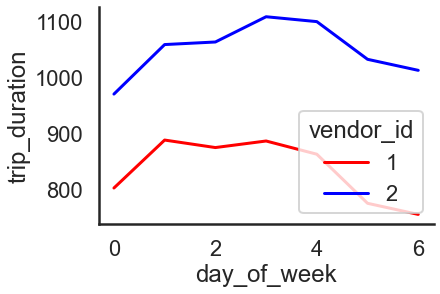

In [35]:
summary_wdays_avg_duration = pd.DataFrame(df.groupby(['vendor_id','day_of_week'])['trip_duration'].mean())
summary_wdays_avg_duration.reset_index(inplace = True)
summary_wdays_avg_duration['unit']=1

sns.set(style="white", palette="muted", color_codes=True)
sns.set_context("poster")
sns.lineplot(data=summary_wdays_avg_duration, x="day_of_week", units = "unit",hue="vendor_id", y="trip_duration",estimator =None,palette=['red', 'blue'])
sns.despine(bottom = False)

### 04.Median Trip Duration Vendor Wise

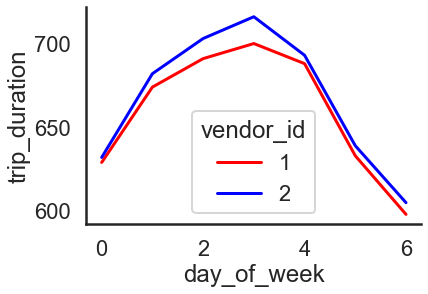

In [36]:
summary_wdays_avg_duration = pd.DataFrame(df.groupby(['vendor_id','day_of_week'])['trip_duration'].median())
summary_wdays_avg_duration.reset_index(inplace = True)
summary_wdays_avg_duration['unit']=1

sns.set(style="white", palette="muted", color_codes=True)
sns.set_context("poster")
sns.lineplot(data=summary_wdays_avg_duration, x="day_of_week", units = "unit",hue="vendor_id", y="trip_duration",estimator =None,palette=['red', 'blue'])
sns.despine(bottom = False)

### Correlation Heatmap

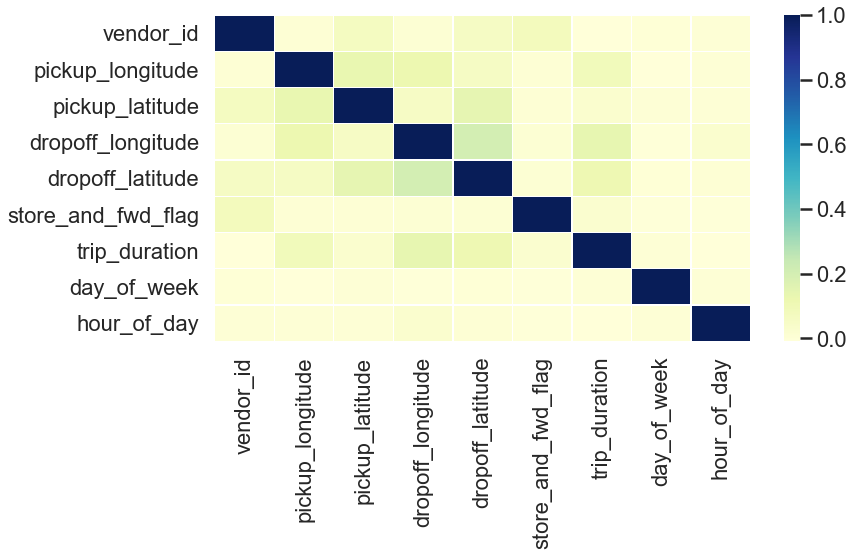

In [39]:
plt.figure(figsize=(12, 6))
df = df.drop(['id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count','check_trip_duration','log_trip_duration'],
        axis=1)
corr = df.apply(lambda x: pd.factorize(x)[0]).corr()
ax = sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, 
                 linewidths=.2, cmap="YlGnBu")

## Preprocessing & Feature Extraction
As is clear from the previous modules, we can only feed numeric features as input to our models. So our next task is to convert the features in numeric form. It is time to jump into getting our data ready for feeding into the model but before that it is important to use the variables to do some feature engineering as t

Some of my ideas to create new variables and the reasons are as follows

* Difference between pickup and dropoff latitude - will give an idea about the distance covered which could be predictive
* Difference between pickup and dropoff longitude - same reason as above
* Haversine distance between pickup and dropoff co-ordinates - to capture the actual distance travelled
* Pickup minute - since pickup hour is an important variable, the minute of pickup might well have been predictive
* Pickup day of year - same reason as above



### Load Data 

In [ ]:
df = pd.read_csv('nyc_taxi_final.zip')

### Distance Features

#### Eucledian Distance
Let's Calculate the Eucledian distance between pickup and drop off location 

In [55]:

#displacement
y_dist= df['pickup_longitude'] - df['dropoff_longitude']
x_dist = df['pickup_latitude'] - df['dropoff_latitude']

#square distance
df['dist_sq'] = (y_dist ** 2) + (x_dist ** 2)

#distance
df['dist_sqrt'] = df['dist_sq'] ** 0.5

#### Haversine Distance
Let's calculate the distance (km) between pickup and dropoff points.

In [56]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def direction_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))


df['haversine_distance'] = haversine_array(df['pickup_latitude'].values, 
                                                     df['pickup_longitude'].values, 
                                                     df['dropoff_latitude'].values, 
                                                     df['dropoff_longitude'].values)


df['direction'] = direction_array(df['pickup_latitude'].values, 
                                          df['pickup_longitude'].values, 
                                          df['dropoff_latitude'].values, 
                                          df['dropoff_longitude'].values)


In [57]:
# For a route, the total distance and travel time are not available. Let's impute that with 0
df.fillna(0, inplace = True)

In [58]:
df = df.drop(['id', 'pickup_datetime', 'dropoff_datetime', 'trip_duration','store_and_fwd_flag'], axis=1)

## Model Building

### Defining Metric

In [59]:
from sklearn.metrics import mean_squared_error
from math import sqrt

### Test Train Split

In [61]:
#Splitting the data into Train and Validation set
from sklearn.model_selection import train_test_split 
xtrain, xtest, ytrain, ytest = train_test_split(df,df_y,test_size=1/3, random_state=0)

### Cross validation
Cross Validation is one of the most important concepts in any type of data modelling. It simply says, try to leave a sample on which you do not train the model and test the model on this sample before finalizing the model.

we divide the entire population into k equal samples. Now we train models on k-1 samples and validate on 1 sample. Then, at the second iteration we train the model with a different sample held as validation. 

In k iterations, we have basically built model on each sample and held each of them as validation. This is a way to reduce the selection bias and reduce the variance in prediction power.

In [62]:
def cv_score(ml_model, rstate = 11,cols = df.columns):
    i = 1
    cv_scores = []
    df1 = df.copy()
    df1 = df[cols]
    
    kf = KFold(n_splits=5,random_state=rstate,shuffle=True)
    for train_index,test_index in kf.split(df1,df_y):
        print('\n{} of kfold {}'.format(i,kf.n_splits))
        xtr,xvl = df1.loc[train_index],df1.loc[test_index]
        ytr,yvl = df_y[train_index],df_y[test_index]

        model = ml_model
        model.fit(xtr, ytr)
        train_val = model.predict(xtr)
        pred_val = model.predict(xvl)
        rmse_score_train = sqrt(mean_squared_error(ytr, train_val))
        rmse_score = sqrt(mean_squared_error(yvl, pred_val))
        sufix = ""
        msg = ""
        #msg += "Train RMSE: {:.5f} ".format(rmse_score_train)
        msg += "Valid RMSE: {:.5f}".format(rmse_score)
        print("{}".format(msg))
        # Save scores
        cv_scores.append(rmse_score)
        i+=1
    return cv_scores

### Linear Regression
Lets begin by using the simplest regression algorithm Linear regression to check the performance.

In [63]:
linreg_scores = cv_score(LinearRegression())


1 of kfold 5
Valid RMSE: 0.61486

2 of kfold 5
Valid RMSE: 0.61431

3 of kfold 5
Valid RMSE: 0.67560

4 of kfold 5
Valid RMSE: 0.69665

5 of kfold 5
Valid RMSE: 0.60711


### Decision Tree

In [64]:
dtree_scores = cv_score(DecisionTreeRegressor(min_samples_leaf=25, min_samples_split=25))


1 of kfold 5
Valid RMSE: 0.43610

2 of kfold 5
Valid RMSE: 0.43855

3 of kfold 5
Valid RMSE: 0.42819

4 of kfold 5
Valid RMSE: 0.43178

5 of kfold 5
Valid RMSE: 0.43187


### Linear Regression Vs Decision Tree

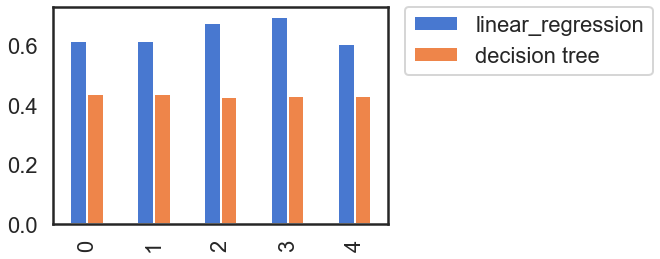

In [67]:
results_df = pd.DataFrame({'linear_regression':linreg_scores, 'decision tree': dtree_scores})


results_df.plot(y=["linear_regression", "decision tree"], kind="bar", legend=False)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

### Decision Tree Visualization

In [68]:
from sklearn import tree

dtree = DecisionTreeRegressor(min_samples_leaf=25, min_samples_split=25)
dtree.fit(xtrain, ytrain)

decision_tree = tree.export_graphviz(dtree,out_file='tree.dot',feature_names=xtrain.columns,max_depth=2,filled=True)
!dot -Tpng tree.dot -o tree.png

'dot' is not recognized as an internal or external command,
operable program or batch file.


<img src="tree.png" width=500 height=500>